<a href="https://colab.research.google.com/github/adityamishra5050/Sentiment-Analysis-of-Company-Reviews-/blob/main/Copy_of_DL_project_transformer_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from tqdm.notebook import tqdm

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DLP/train.csv')


In [ ]:
df.head()

,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


In [ ]:
df.Rating.value_counts()

5    34679
1    18663
4     3350
3     1679
2     1629
Name: Rating, dtype: int64

In [ ]:
possible_labels = df.Rating.unique()

In [ ]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [ ]:
label_dict

{5: 0, 3: 1, 1: 2, 4: 3, 2: 4}

In [ ]:
df.Rating = df['Rating'].map(label_dict)

In [ ]:
df.head(10)

,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,0
1,1,After 6 month still can't access my account,1
2,2,I couldn't make an official review on a produc...,2
3,3,"Fantastic! Extremely easy to use website, fant...",0
4,4,So far annoyed as hell with this bt monthly pa...,2
5,5,Correct replacement delivered on time now my v...,0
6,6,"Now Tv have the worst Broadband, it has gotten...",2
7,7,"Everything happened as you said, delivery grea...",0
8,8,Quick and fast delivery. Website was easy to u...,0
9,9,This is by far the most shocking experience I’...,2


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.Rating.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=df.Rating.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

In [ ]:
df.head()

,Id,Review,Rating,data_type
0,0,Very good value and a great tv very happy and ...,0,not_set
1,1,After 6 month still can't access my account,1,not_set
2,2,I couldn't make an official review on a produc...,2,not_set
3,3,"Fantastic! Extremely easy to use website, fant...",0,not_set
4,4,So far annoyed as hell with this bt monthly pa...,2,not_set


In [ ]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['Rating', 'data_type']).count()

Id  Review
Rating data_type               
0      train      29477   29477
       val         5202    5202
1      train       1427    1427
       val          252     252
2      train      15864   15864
       val         2799    2799
3      train       2847    2847
       val          503     503
4      train       1385    1385
       val          244     244

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.6 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Review.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].Review.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].Rating.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].Rating.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val,
                            attention_masks_val,
                           labels_val)

In [ ]:
len(dataset_train)

51000

In [ ]:
dataset_val.tensors

(tensor([[  101,  1045,  2481,  ...,     0,     0,     0],
         [  101,  6429,  2194,  ...,     0,     0,     0],
         [  101,  2005,  3737,  ...,     0,     0,     0],
         ...,
         [  101,  2092,  6727,  ...,     0,     0,     0],
         [  101,  2022,  8059,  ...,     0,     0,     0],
         [  101, 28117,  2532,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([2, 0, 0,  ..., 0, 2, 0]))

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased',
                                      num_labels = len(label_dict),
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
batch_size = 4

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 3

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = len(dataloader_train)*epochs
)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted'), accuracy_score(labels_flat, preds_flat)

In [ ]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(torch.Tensor(preds)))
    correct = (rounded_preds == y) #convert into float for division
    correct = correct.flot()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [ ]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0

    predictions, true_vals = [], []

    for batch in tqdm(dataloader_val):

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)



    return loss_val_avg, predictions, true_vals

In [ ]:
Training_Loss = []
Training_Acc = []
Training_F1_score = []

Validation_Loss = []
Validation_Acc = []
Validation_F1_score = []

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0



    progress_bar = tqdm(dataloader_train,
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)

    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total +=loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})



    tqdm.write('\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    train_loss, predictions1, true_vals1 = evaluate(dataloader_train)
    train_f1,train_acc = f1_score_func(predictions1, true_vals1)

    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1,val_acc = f1_score_func(predictions, true_vals)

    tqdm.write(f'training loss: {train_loss}')
    tqdm.write(f'F1 Score_training (weighted): {train_f1}')
    tqdm.write(f'training Accuracy: {train_acc}')

    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')
    tqdm.write(f'Accuracy: {val_acc}')

    Training_Loss.append(train_loss)
    Training_Acc.append(train_acc)
    Training_F1_score.append(train_f1)

    Validation_Loss.append(val_loss)
    Validation_Acc.append(val_acc)
    Validation_F1_score.append(val_f1)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/12750 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.46295492187080284


  0%|          | 0/12750 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

training loss: 0.3874107097531349
F1 Score_training (weighted): 0.884705984280003
training Accuracy: 0.9069019607843137
Validation loss: 0.49175526241686013
F1 Score (weighted): 0.864769855251674
Accuracy: 0.8907777777777778


Epoch 2:   0%|          | 0/12750 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.364791626321444


  0%|          | 0/12750 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

training loss: 0.2531530478210828
F1 Score_training (weighted): 0.923608908198142
training Accuracy: 0.933078431372549
Validation loss: 0.45946063538055526
F1 Score (weighted): 0.8794707831314965
Accuracy: 0.8936666666666667


Epoch 3:   0%|          | 0/12750 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.29020268039658037


  0%|          | 0/12750 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

training loss: 0.21819215340863266
F1 Score_training (weighted): 0.9434415936605864
training Accuracy: 0.9481176470588235
Validation loss: 0.5473909514856273
F1 Score (weighted): 0.8794028696378895
Accuracy: 0.8906666666666667


In [ ]:
accuracy_per_class(predictions, true_vals)

Class: 5
Accuracy:5057/5202

Class: 3
Accuracy:64/252

Class: 1
Accuracy:2685/2799

Class: 4
Accuracy:170/503

Class: 2
Accuracy:40/244



In [ ]:
import matplotlib.pyplot as plt


In [ ]:
import os

[[5057   10   23  107    5]
 [  26   64   68   63   31]
 [  18   38 2685    7   51]
 [ 271   37   15  170   10]
 [   7   39  151    7   40]]


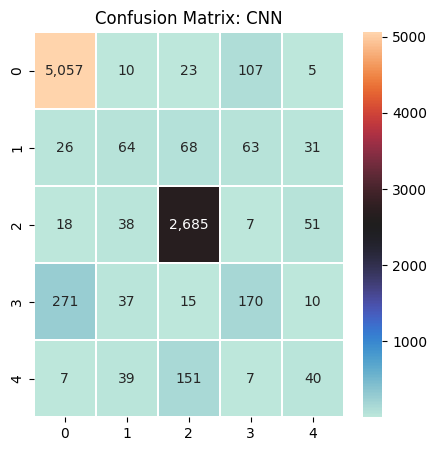

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(true_vals, predictions.argmax(axis=1))
print(conf_mat)
import seaborn as sns
plt.figure(figsize=(5, 5))
sns.heatmap(conf_mat, cmap='icefire', annot=True, linewidths=0.1,
           fmt = ',')
plt.title('Confusion Matrix: CNN',fontsize=12);

In [ ]:
Training_Loss


[0.3874107097531349, 0.2531530478210828, 0.21819215340863266]

In [ ]:
Validation_Loss

[0.49175526241686013, 0.45946063538055526, 0.5473909514856273]

In [ ]:
Validation_Acc

[0.8907777777777778, 0.8936666666666667, 0.8906666666666667]

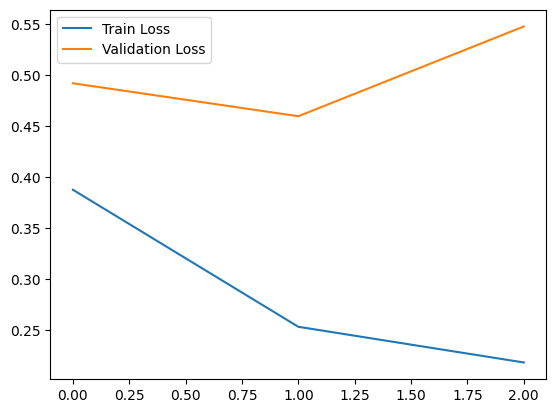

In [ ]:
plt.plot(Training_Loss, label='Train Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.legend()
plt.show()

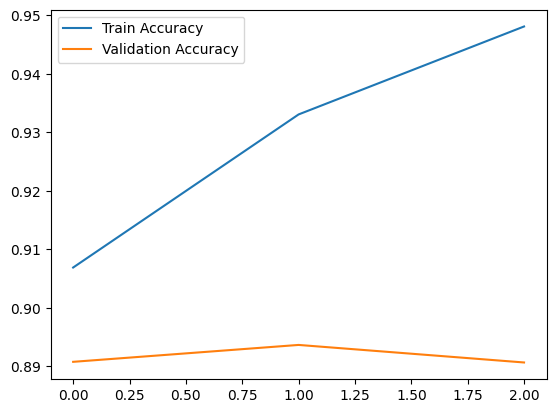

In [ ]:
plt.plot(Training_Acc, label='Train Accuracy')
plt.plot(Validation_Acc, label='Validation Accuracy')
plt.legend()
plt.show()